In [118]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180

In [119]:
import numpy as np
import matplotlib.lines as mlines

P = 19
A = -3
B = 5

# Following two functions for inverting number on field of integers modulo p are from
# https://andrea.corbellini.name/2015/05/23/elliptic-curve-cryptography-finite-fields-and-discrete-logarithms/
def extended_euclidean_algorithm(a, b):
    """
    Returns a three-tuple (gcd, x, y) such that
    a * x + b * y == gcd, where gcd is the greatest
    common divisor of a and b.

    This function implements the extended Euclidean
    algorithm and runs in O(log b) in the worst case.
    """
    s, old_s = 0, 1
    t, old_t = 1, 0
    r, old_r = b, a

    while r != 0:
        quotient = old_r // r
        old_r, r = r, old_r - quotient * r
        old_s, s = s, old_s - quotient * s
        old_t, t = t, old_t - quotient * t

    return old_r, old_s, old_t


def inverse_of(n, p):
    """
    Returns the multiplicative inverse of
    n modulo p.

    This function returns an integer m such that
    (n * m) % p == 1.
    """
    gcd, x, y = extended_euclidean_algorithm(n, p)
    assert (n * x + p * y) % p == gcd

    if gcd != 1:
        # Either n is 0, or p is not a prime number.
        raise ValueError(
            '{} has no multiplicative inverse '
            'modulo {}'.format(n, p))
    else:
        return x % p

    
class Point:
    def __init__(self, p, x=float('inf'), y=float('inf')):
        self.p = p
        self.x = x % p
        self.y = y % p
        
    def __repr__(self):
        return "Point(p={}, x={}, y={})".format(self.p, self.x, self.y)
    
    def __add__(self, other):
        assert type(other) is Point
        if self.x == other.x and self.y == other.y:
            return self.double()
        dx = other.x - self.x
        dy = other.y - self.y
        if dx == 0:
            return Point()
        slope = dy * inverse_of(dx, self.p)
        x = (slope ** 2) - self.x - other.x
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def double(self):
        slope = (3 * (self.x ** 2) + A) * inverse_of(2 * self.y, self.p)
        x = (slope ** 2) - (2 * self.x)
        y = slope * x + (self.y - slope * self.x)
        x %= self.p
        y %= self.p
        return Point(self.p, x, -y)
    
    def oppsite(self):
        return Point(self.p, self.x, -self.y)
    
    def np(self):
        return np.array([self.x, self.y])
    

In [120]:
import matplotlib.pyplot as plt

def enumerate_points(p):
    # TODO: this is silly way, maybe there's a better way
    for x in range(p):
        for y in range(p):
            if (y ** 2) % p == ((x ** 3) + A * x + B) % p:
                yield (x, y)

                
def plot_curve(p, a, b, ax):
    points = list(enumerate_points(p))
    points = np.array(points)
    # print(points)

    ax.scatter(points[:,0], points[:,1], zorder=5)
    ax.set_axisbelow(True)
    ax.grid()
    
    ax.set_ylim(top=p)
    ax.set_ylim(bottom=0)
    ax.set_xlim(left=0)
    ax.set_xlim(right=p)

In [127]:
import math
import heapq
from matplotlib.ticker import MaxNLocator


def wrap_line_segments(p0, p1):
    """Get line segments of the line between p0 and p1 that gets cut by edges
    
    """
    p0x, p0y = p0
    p1x, p1y = p1
    
    # grid block index
    x_start_idx = (p0x // P) + 1
    x_end_idx = p1x // P
    y_start_idx = (p0y // P) + 1
    y_end_idx = p1y // P
    
    dx = p1x - p0x
    dy = p1y - p0y
    slope = dy / dx
    
    x_stops = [p0x] + list(map(lambda x: x * P, range(x_start_idx, x_end_idx))) + [p1x]
    y_stops = [p0y] + list(map(lambda x: y * P, range(y_start_idx, y_end_idx))) + [p1y]
    
    x_stop_points = list(map(lambda x: (x, x * slope), x_stops))
    y_stop_points = list(map(lambda y: (y / slope, y), y_stops))
    
    # merge two list of points stop at edge by the order of distance to p0
    return list(heapq.merge(
        x_stop_points,
        y_stop_points,
        key=lambda point: (point[0] - p0x) ** 2 + (point[1] - p0y) ** 2)
    )

    
def plot_distinct_point_curve(p0, p1, p0_annotation, p1_annotation, third_point_annotation, sum_point_annotation):
    p2 = p0 + p1

    fig, ax = plt.subplots()

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    plot_curve(P, A, B, ax)

    dx = p1.x - p0.x
    dy = p1.y - p0.y
    
    dx_dy_gcd = math.gcd(dx, dy)
    dx = int(dx / dx_dy_gcd)
    dy = int(dy / dx_dy_gcd)
    
    cx = p0.x
    cy = p0.y
    
    p2_flip = -p2.y % P
    
    while (cx % P) != p2.x or (cy % P) != p2_flip:
        cx += dx
        cy += dy
        
#         newx = cx
#         newy = cy
#         newx += dx
#         newy += dy
#         ax.add_line(mlines.Line2D([cx, newx], [cy, newy], color='r', zorder=1))
#         newx %= P
#         newy %= P
#         # If the line cross edge, let's draw the second part from the pointer after warping
#         if newx < cx or newy < cy:
#             ax.add_line(mlines.Line2D([newx - dx, newx], [newy - dy, newy], color='r', zorder=1))
#         cx = newx
#         cy = newy

    print(wrap_line_segments((p0.x, p0.y), (cx, cy)))

    ax.annotate(p0_annotation, xy=p0.np(), xytext=(-5, 5), textcoords='offset points')
    ax.annotate(p1_annotation, xy=p1.np(), xytext=(-5, 5), textcoords='offset points')
    ax.annotate(sum_point_annotation, xy=p2.np(), xytext=(-5, 5), textcoords='offset points')
    
    plt.show()

[(0.25, 2), (2.375, 19), (3, 24.0), (4.75, 38), (7.125, 57), (9.5, 76), (11.875, 95), (15.25, 122), (18, 144.0)]


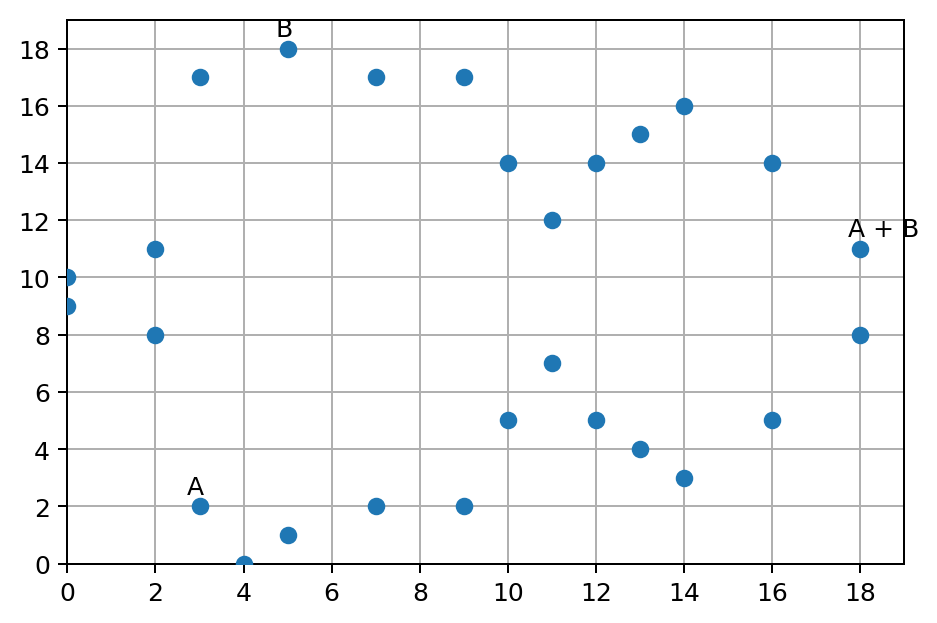

Point(p=19, x=18, y=11)

In [128]:
a = Point(P, 3, 2)
b = Point(P, 5, 18)
c = Point(P, 10, 14)
plot_distinct_point_curve(
    a, b,
    'A', 'B', '', 'A + B'
)
a + b

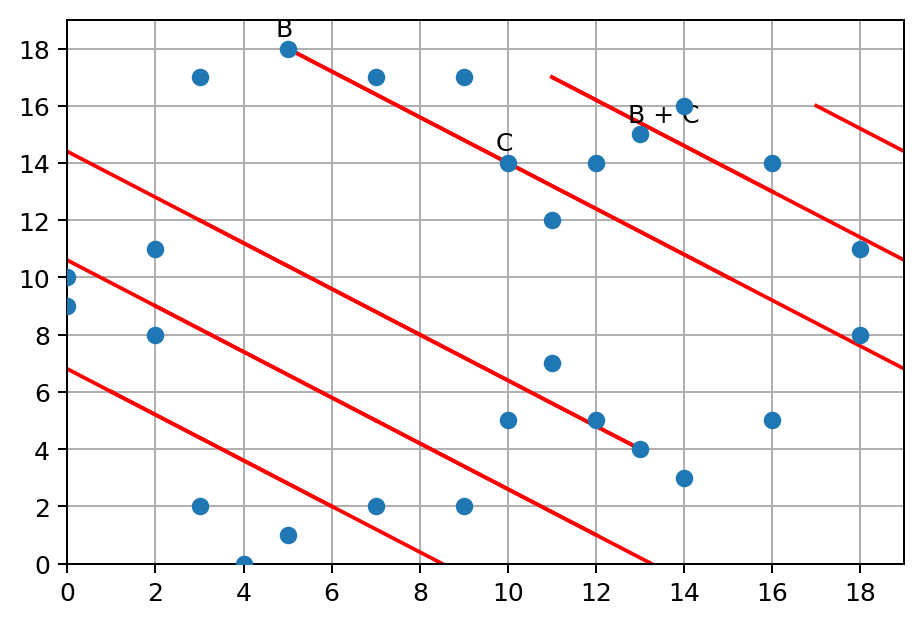

Point(p=19, x=13, y=15)

In [123]:
plot_distinct_point_curve(
    b, c,
    'B', 'C', '', 'B + C'
)
b + c

In [124]:
(a + b) + c, a + (b + c)

(Point(p=19, x=14, y=16), Point(p=19, x=14, y=16))